In [12]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime

import yfinance as yf
from arch import arch_model 
plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

In [5]:
# !pip install yfinance
# !pip install copulae
# https://copulae.readthedocs.io/en/latest/getting-started.html

###  Скачиваем котировки компаний Apple, HSBC и Toyota

In [3]:
data = yf.download("AAPL HSBC TM", start="2015-01-01", end="2019-01-01", group_by="ticker")

data.head()

[*********************100%***********************]  3 of 3 completed


AAPL                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2014-12-31  112.820000  113.129997  110.209999  110.379997  101.419060   
2015-01-02  111.389999  111.440002  107.349998  109.330002  100.454300   
2015-01-05  108.290001  108.650002  105.410004  106.250000   97.624336   
2015-01-06  106.540001  107.430000  104.629997  106.260002   97.633545   
2015-01-07  107.199997  108.199997  106.699997  107.750000   99.002556   

                           HSBC                                              \
              Volume       Open       High        Low      Close  Adj Close   
Date                                                                          
2014-12-31  41403400  47.490002  47.549999  47.180000  47.230000  34.711212   
2015-01-02  53204600  47.299999  47.330002  46.849998  47.070000  34.593620   
2015-01-05  64285500  46.259998  46.340000  45.799999  45.990002  33.799889   
2015-01-06  65797100  45.439999  45.680000  45.009998  45.320000  33.307472   
2015-01-07  40105900  45.459999  45.720001  45.230000  45.669998  33.564701   

                             TM                                      \
             Volume        Open        High         Low       Close   
Date                                                                  
2014-12-31  1178400  125.599998  126.209999  125.400002  125.480003   
2015-01-02  1446500  126.230003  126.639999  124.889999  125.669998   
2015-01-05  2599600  124.440002  124.610001  123.050003  123.370003   
2015-01-06  3408100  123.400002  123.720001  121.209999  122.099998   
2015-01-07  2122400  125.519997  126.059998  125.059998  125.169998   

                                
             Adj Close  Volume  
Date                            
2014-12-31  107.120560  151100  
2015-01-02  107.282745  250000  
2015-01-05  105.319267  240600  
2015-01-06  104.235085  285600  
2015-01-07  106.855896  385700

In [4]:
prices = []

for ticker in data.columns.levels[0]:

    temp = data[ticker]['Close']
    temp.name = ticker
    prices.append(temp)

prices = pd.concat(prices, axis=1)

prices.head()

,AAPL,HSBC,TM
Date,,,
2014-12-31,110.379997,47.230000,125.480003
2015-01-02,109.330002,47.070000,125.669998
2015-01-05,106.250000,45.990002,123.370003
2015-01-06,106.260002,45.320000,122.099998
2015-01-07,107.750000,45.669998,125.169998


###  Строим график цен и смотрим на него

Text(0.5,1,'Stock price')

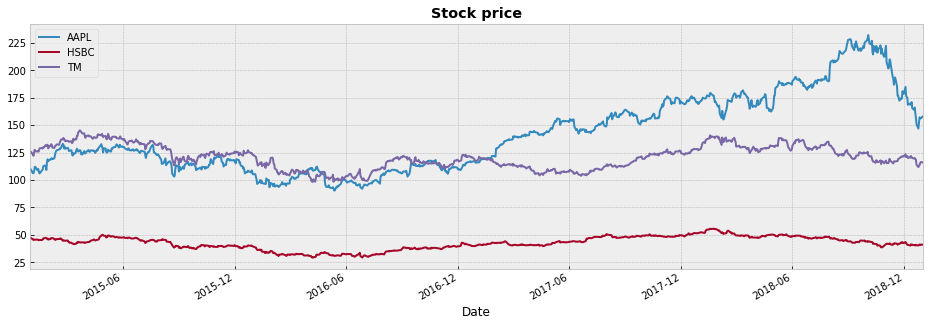

In [5]:
prices.plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

###  Теперь посмотрим на графики доходностей

In [6]:
returns = 100*prices.pct_change().dropna()

returns.head()

,AAPL,HSBC,TM
Date,,,
2015-01-02,-0.951255,-0.338767,0.151414
2015-01-05,-2.817161,-2.294451,-1.830187
2015-01-06,0.009414,-1.456843,-1.029427
2015-01-07,1.402219,0.772283,2.514332
2015-01-08,3.842227,0.328447,1.925384


Text(0.5,1,'Daily returns')

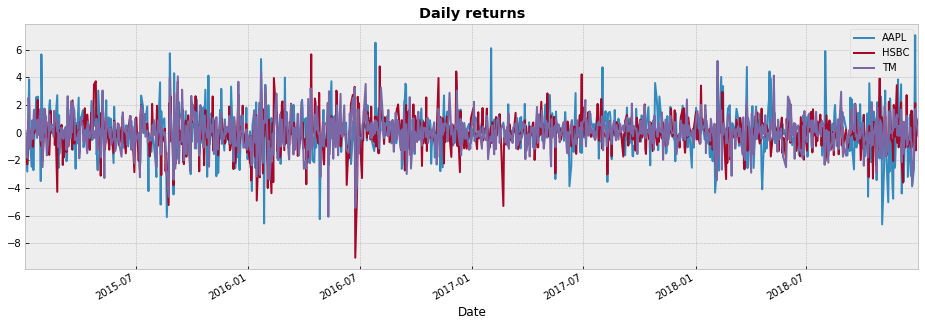

In [7]:
returns.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")

Text(0.5,1,'Daily returns')

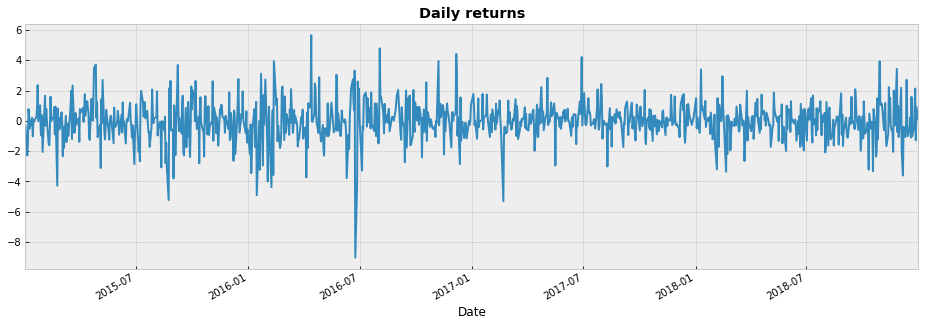

In [8]:
ret = returns['HSBC']

ret.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")

### Теперь, когда мы научились моделировать распределение доходностей и предсказывать Value-at-Risk, нужно двигаться дальше -- предсказывать его на регулярной основе и использовать для управления портфелем

### Но сначала нам нужно посмотреть, как мы делаем предсказания Value-at-Risk различными моделями, и выбрать наилучшую

### Для этого мы будем делать бэктестирование -- проходиться скользящим окном по нашим данным и делать предсказание на каждый следующий день

In [9]:
def calculate_var_HS(returns, alpha):
    
    return returns.quantile(alpha)


def calculate_var_gennorm(returns, alpha):
    beta, loc, scale = scipy.stats.gennorm.fit(returns)
    
    return scipy.stats.gennorm.ppf(alpha, beta, loc, scale)


def calculate_var_garch(returns, alpha):
    
    scaling_const = 1.0 #10 / ret_estimation.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return return_garch_forecast, VaR_garch_forecast

In [10]:
ret = returns['AAPL']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

In [13]:
alpha = 0.01

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_gennorm = []
VaR_curve_garch = []
forecast_garch = []

for t in range(estimation_window+T_start, T):
    
    current_estimation_sample = ret[t-estimation_window:t]

    VaR_curve_HS.append(calculate_var_HS(current_estimation_sample, alpha))
    VaR_curve_gennorm.append(calculate_var_gennorm(current_estimation_sample, alpha))
    
    return_garch_forecast, VaR_garch_forecast = calculate_var_garch(current_estimation_sample, alpha)
    forecast_garch.append(return_garch_forecast)
    VaR_curve_garch.append(VaR_garch_forecast)
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_gennorm = pd.Series(VaR_curve_gennorm, index=ret[estimation_window+T_start:].index)
VaR_curve_garch = pd.Series(VaR_curve_garch, index=ret[estimation_window+T_start:].index)
forecast_garch = pd.Series(forecast_garch, index=ret[estimation_window+T_start:].index)

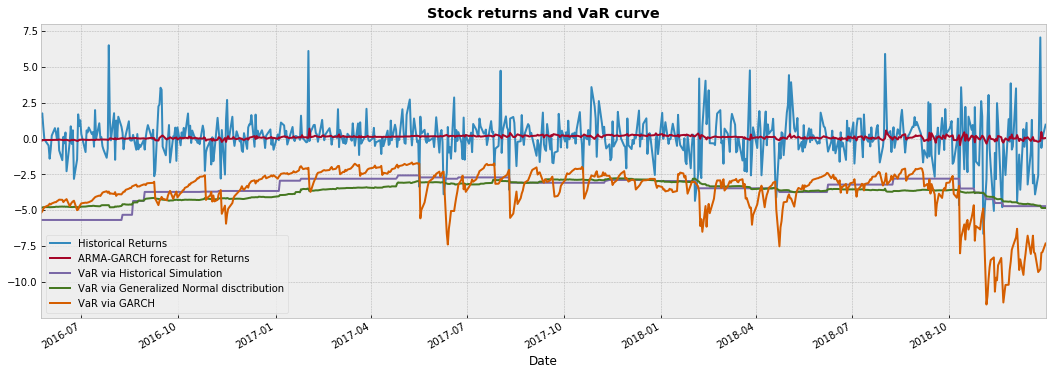

In [128]:
fig = plt.figure()
fig.set_size_inches(18,6)
ret[estimation_window+T_start:].plot()
forecast_garch.plot()
VaR_curve_HS.plot()
VaR_curve_gennorm.plot()
VaR_curve_garch.plot()

plt.title("Stock returns and VaR curve", weight="bold")

plt.legend(['Historical Returns',
            'ARMA-GARCH forecast for Returns',
            'VaR via Historical Simulation',
            'VaR via Generalized Normal disctribution',
           'VaR via GARCH'])

### Таким образом, мы для каждого способа моделирования получили кривую VaR

### Открытые вопросы -- какой способ подсчета VaR выбрать? И Как моделировать доходность портфеля из нескольких активов?

###  Для выбора подходящей модели будем использовать тест Купика, который сравнивает модельную и реальную частоту пробоев

In [143]:
def kupiec_test(VaR_curve, actual_returns, pp=0.1):
    
    T = len(actual_returns)
    K = (actual_returns < VaR_curve).sum()
    alpha_0 = K / T
    
    S = -2*np.log((1-alpha)**(T-K) * alpha**K) + 2*np.log((1-alpha_0)**(T-K) * alpha_0**K)
    p_value = 1 - scipy.stats.chi2.cdf(S, df=1)
        
    if np.isnan(p_value):
        p_value = 0.
        
    print('Количество наблюдений:', T)
    print('Желаемый уровень пробитий: {:.1f}%'.format(alpha*100))
    print('Уровень пробитий в модели: {:.2f}%'.format(alpha_0*100))
        
    print('\np-value теста: {:.3f}'.format(p_value))
    if p_value > pp:
        print("""\nПри уровне значимости {:.0f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ""".format(pp*100))
    else:
        print("""\nПри уровне значимости {:.1f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается""".format(pp*100))

In [144]:
kupiec_test(VaR_curve_gennorm, ret[estimation_window+T_start:])

Количество наблюдений: 656
Желаемый уровень пробитий: 1.0%
Уровень пробитий в модели: 1.37%

p-value теста: 0.365

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [145]:
kupiec_test(VaR_curve_garch, ret[estimation_window+T_start:])

Количество наблюдений: 656
Желаемый уровень пробитий: 1.0%
Уровень пробитий в модели: 1.22%

p-value теста: 0.585

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


###  Теперь мы будем моделировать совместное распределение длходностей активов, чтобы подсчитать Value-at-Risk всего портфеля

###  Сначала посмотрим на историческое распределение доходностей двух акций

Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

<Figure size 432x432 with 0 Axes>

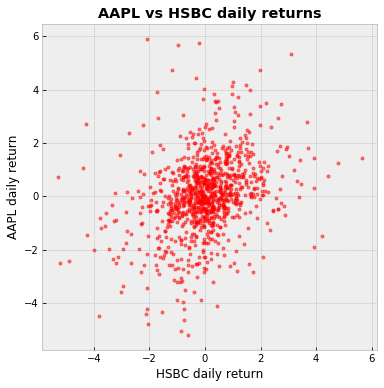

In [247]:
idx = (returns['HSBC'] > -6) & (returns['HSBC'] < 6)
idx = idx & (returns['AAPL'] > -6) & (returns['AAPL'] < 6)

x = returns.loc[idx, 'HSBC']
y = returns.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)

plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

###  Мы можем смоделировать частные распределения с помощью уже известных нам распределений, например Стьюдента

In [253]:
n_samples = 10 ** 5

return_simulations = {}

# для каждой акции оцениваем одномерное распределение, а потом сэмплируем из него новые псевдо-наблюдения
for col in returns.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
    return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

In [249]:
return_simulations.shape

(100000, 3)

In [250]:
returns.head()

,HSBC,TM,AAPL
Date,,,
2015-01-02,-0.338768,0.151419,-0.951259
2015-01-05,-2.294455,-1.830190,-2.817159
2015-01-06,-1.456838,-1.029424,0.009412
2015-01-07,0.772286,2.514333,1.402221
2015-01-08,0.328443,1.925381,3.842227


In [254]:
np.cov(returns.values, rowvar=False)

array([[1.68594157, 0.78700997, 0.64448564],
       [0.78700997, 1.46776396, 0.7583473 ],
       [0.64448564, 0.7583473 , 2.37832215]])

In [255]:
np.cov(return_simulations.values, rowvar=False)

array([[ 1.88898689e+00,  1.18783728e-03, -5.14381718e-03],
       [ 1.18783728e-03,  1.54012135e+00, -7.93891401e-03],
       [-5.14381718e-03, -7.93891401e-03,  2.90089824e+00]])

In [248]:
return_simulations.head()

,AAPL,TM,HSBC
0,-0.512255,1.860260,0.527571
1,-1.138597,-1.929090,-1.892345
2,-3.192208,0.831033,-0.066459
3,1.031781,-1.550834,2.233011
4,2.797398,-0.139401,-0.213662


Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

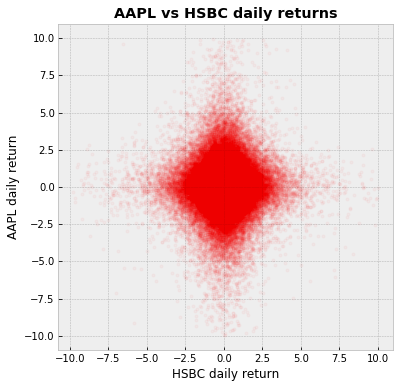

In [19]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

###  Однако, как мы видим, здесь никак не учитываются корреляции между активами -- надо это как-то исправлять!

###  Один из способов это сделать -- использовать многомерные распределения, например многомерное нормальное распределение

In [256]:
n_samples = 10 ** 5

# оцениваем параметры нормального распределения
mean = np.mean(returns.values, axis=0)
cov = np.cov(returns.values, rowvar=False)

# а потом сэмплируем из него новые псевдо-наблюдения
return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

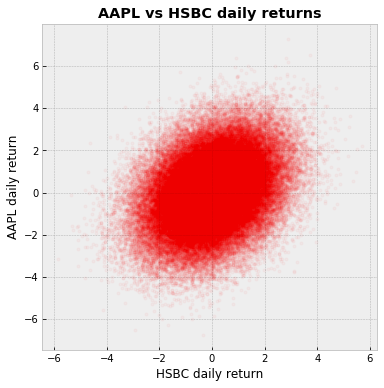

In [264]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

###  Выглядит, конечно, не очень похоже на правду, но уже лучше. Давайте подсчитаем VaR в таком случае для портфеля с одинаковыми весами

In [258]:
w = np.ones(shape=(returns.shape[1],)) / 3
w

array([0.33333333, 0.33333333, 0.33333333])

In [260]:
alpha = 0.05

In [261]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.7687777944642444
-1.7118070903264326


###  И эмпирическая квантиль, и квантиль многомерного нормального распределения похожи -- вроде бы все нормально

###  Давате посмотрим на гистограмму распределения доходностей портфеля

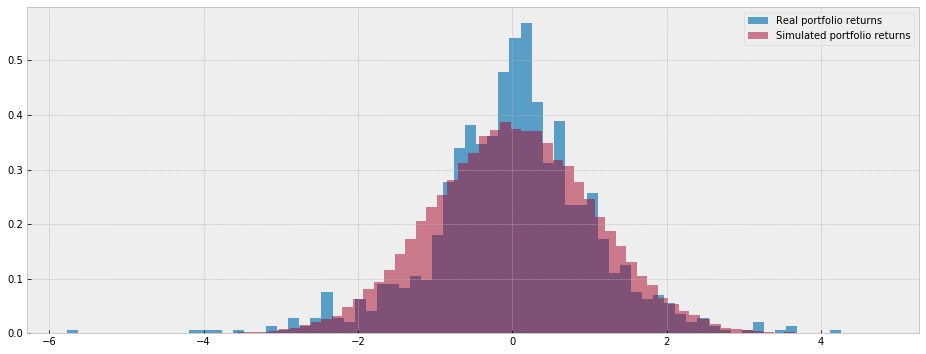

In [29]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(portfolio_real_returns, bins=70, density=True, alpha=0.8, label='Real portfolio returns')
plt.hist(portfolio_simulated_returns, bins=70, density=True, alpha=0.5, label='Simulated portfolio returns')
plt.legend(loc='upper right')

###  Как видно, распределения очень сильно отличаются -- плохо будем думать дальше

###  И следующий наш шаг -- использование копул для моделирования нелинейных зависимостей между активами

In [15]:
from copulae import NormalCopula, GaussianCopula, StudentCopula

###  Сначала мы моделируем частные распределения активов. например с помощью распределения Стьюдента

In [17]:
cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [18]:
distribution_params

{'AAPL': (3.126031654997381, 0.07253602048848248, 1.0221935908120252),
 'HSBC': (3.4818989384736465, 0.012616265164582578, 0.8955178979625749),
 'TM': (4.620458302974767, 0.01477273033458118, 0.9317168640140594)}

###  Вот так выглядят доходности

Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

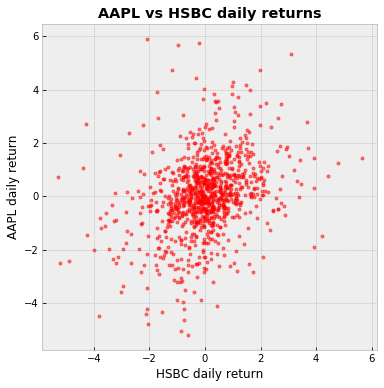

In [267]:
idx = (returns['HSBC'] > -6) & (returns['HSBC'] < 6)
idx = idx & (returns['AAPL'] > -6) & (returns['AAPL'] < 6)

x = returns.loc[idx, 'HSBC']
y = returns.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

###  А вот так выглядит распределение их квантилей

Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

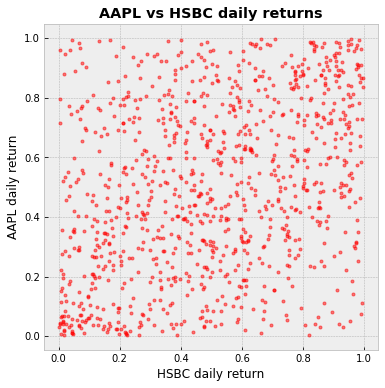

In [268]:
x = cdfs['HSBC']
y = cdfs['AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

In [270]:
returns.head()

,HSBC,TM,AAPL
Date,,,
2015-01-02,-0.338768,0.151419,-0.951259
2015-01-05,-2.294455,-1.830190,-2.817159
2015-01-06,-1.456838,-1.029424,0.009412
2015-01-07,0.772286,2.514333,1.402221
2015-01-08,0.328443,1.925381,3.842227


In [269]:
cdfs.head()

,HSBC,TM,AAPL
Date,,,
2015-01-02,0.358797,0.555208,0.193825
2015-01-05,0.035322,0.054622,0.031624
2015-01-06,0.093324,0.158624,0.477249
2015-01-07,0.774687,0.976318,0.859548
2015-01-08,0.627690,0.949905,0.983877


###  Оценим Нормальную копулу и посмотрим на ее описание

In [19]:
cop = NormalCopula(dim=3)
cop.fit(cdfs)

In [20]:
cop.summary()

Gaussian Copula Summary
================================================================================
Gaussian Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
 1.000000  0.34831  0.413125
 0.348310  1.00000  0.488550
 0.413125  0.48855  1.000000



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -244.0237296597628
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1006

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [0.34831036 0.41312544 0.48854993]
	fun            : -244.0237296597628
	jac            : [-0.00015916  0.00026148  0.00022358]
	nit            : 8
	nfev           : 46
	njev           : 8
	status         : 0
	message        : Optimization terminated successfully.
	success        : True

###  Теперь мы можем сэмплировать частные квантили с помощью оцененной копулы, и можем построить их распределение

In [273]:
n_samples = 10 ** 5

copula_simulations = cop.random(n_samples, seed=42)

copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

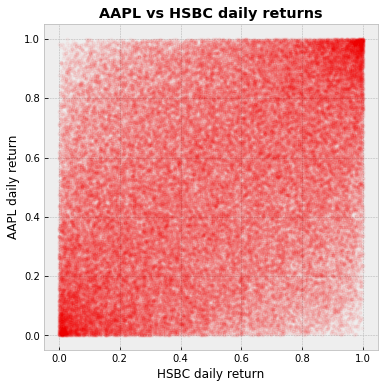

In [274]:
x = copula_simulations['HSBC']
y = copula_simulations['AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

###  Выглядит супер! Правда непонятно -- давайте вернемся от квантилей к доходностям с помощью inverse CDF и посмотрим на распределение сэмплов

In [276]:
return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    t_df, t_mean, t_sigma = distribution_params[col]
    return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

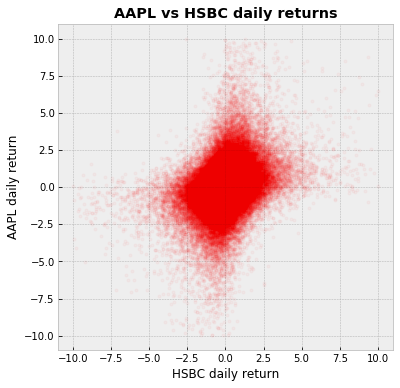

In [279]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

###  Выглядит интересно! Зависимость нелинейная

###  Давайте посчитаем квантиль в данном случае, а затем посмотрим на гистограммы

In [280]:
portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.7687777944642444
-1.6581373177736436


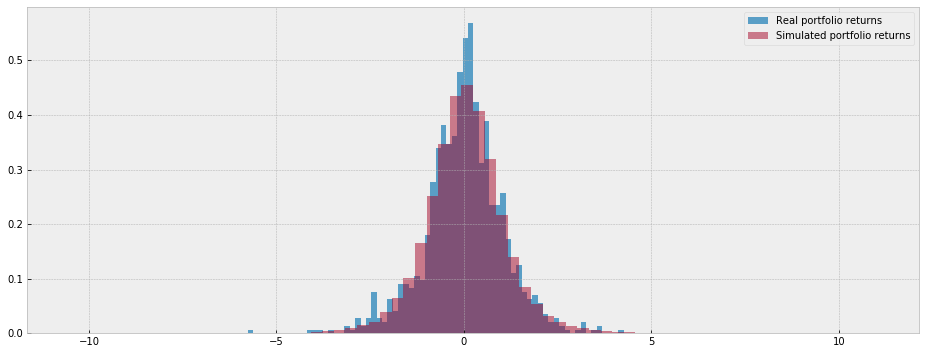

In [281]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(portfolio_real_returns, bins=70, density=True, alpha=0.8, label='Real portfolio returns')
plt.hist(portfolio_simulated_returns[idx], bins=70, density=True, alpha=0.5, label='Simulated portfolio returns')
plt.legend(loc='upper right')

###  Выглядит лучше! Но мы и на этом не остановимся

### Во-вервых, можно использовать другие копулы и другие частные распределения

In [73]:
from copulae import ClaytonCopula, FrankCopula, GumbelCopula

In [282]:
univariate_dist = 'gennorm' # gennorm
cop = ClaytonCopula(dim=cdfs.shape[1])
n_samples = 10 ** 5

cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
        distribution_params[col] = (t_df, t_mean, t_sigma)
        cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = scipy.stats.gennorm.fit(cdfs[col])
        distribution_params[col] = (beta, loc, scale)
        cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

cop.fit(cdfs)

copula_simulations = cop.random(n_samples, seed=42)
copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = distribution_params[col]
        return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = distribution_params[col]
        return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

In [283]:
portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.7687777944642444
-1.7413912550109443


Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

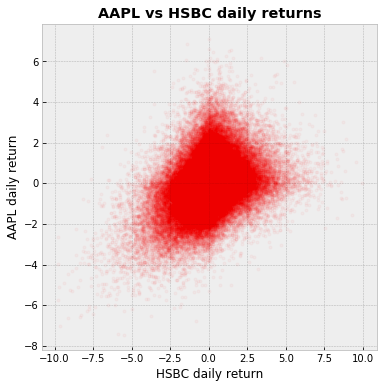

In [286]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'AAPL']
y = return_simulations.loc[idx, 'TM']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

###  Тут зависимость оценилась другая -- надо будет проводить бэктест

###  А во-вторых, можно использовать ARMA-GARCH для учета временной структуры доходностей

###  Для удобства напишем нужные нам функции

In [83]:
from arch import arch_model 

In [154]:
# ret = returns['AAPL']
# dist = 'ged'

def get_garch_residuals(ret, dist):

    # объявляем GARCH модель
    am = arch_model(ret,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')

    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-2:])
        
    return cdf, am, res


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return cond_mean + np.sqrt(cond_var) * q

In [155]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res = get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res)
            cdfs[col] = cdf

    # фитим копулу
    cop.fit(cdfs)

    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

###  Посмотрим, как можно использовать все эти замечательные функции

In [287]:
return_simulations = make_copula_simulation(returns, ClaytonCopula, n_samples=10**5, univariate_dist='garch')

In [288]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 3

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.7687777944642444
-2.2418101473405905


Text(0.5, 1.0, 'AAPL vs HSBC daily returns')

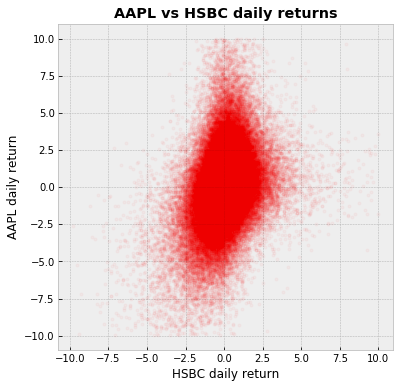

In [289]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")

###  И теперь перейдем к бэктесту -- напишем еще пару функций для моделирования совместного распределения доходностей

In [161]:
def make_dummy_student_simulations(returns, n_samples):
    
    return_simulations = {}

    for col in returns.columns:
        t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
        return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations


def make_mult_normal_simulations(returns, n_samples):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations


###  И наконец-то перейдем к самому бэктесту!

In [189]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 3

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 500
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_student = []
VaR_curve_multivariate_normal = []
VaR_curve_copula_t = []
VaR_curve_copula_garch = []

# в цикле проходимся по всем дням в выборке
for t in range(estimation_window+T_start, T):
    
    # фиксируем часть выборки
    current_estimation_sample = returns[t-estimation_window:t]
    
    # различными способами оцениваем ВаР и сохраняем значения
    protfolio = np.dot(current_estimation_sample.values, w)
    VaR_curve_HS.append(np.quantile(protfolio, alpha))
    
    student_simulation = make_dummy_student_simulations(current_estimation_sample, 10**4)
    VaR_curve_student.append(np.quantile(np.dot(student_simulation.values, w), alpha))
    
    multivariate_normal_simulation = make_mult_normal_simulations(current_estimation_sample, 10**4)
    VaR_curve_multivariate_normal.append(np.quantile(np.dot(multivariate_normal_simulation.values, w), alpha))
    
    copula_t_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='t')
    VaR_curve_copula_t.append(np.quantile(np.dot(copula_t_simulation.values, w), alpha))
    
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula,
                                                     n_samples=10**4, univariate_dist='garch')
    VaR_curve_copula_garch.append(np.quantile(np.dot(copula_garch_simulation.values, w), alpha))
    
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_student = pd.Series(VaR_curve_student, index=ret[estimation_window+T_start:].index)
VaR_curve_multivariate_normal = pd.Series(VaR_curve_multivariate_normal, index=ret[estimation_window+T_start:].index)

VaR_curve_copula_t = pd.Series(VaR_curve_copula_t, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_garch = pd.Series(VaR_curve_copula_garch, index=ret[estimation_window+T_start:].index)

portfolio = np.dot(returns[estimation_window+T_start:].values, w)
portfolio = pd.Series(portfolio, index=ret[estimation_window+T_start:].index)

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9904. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9843. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9815. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSca

###  Посмотрим на график доходностей и на VaR кривые

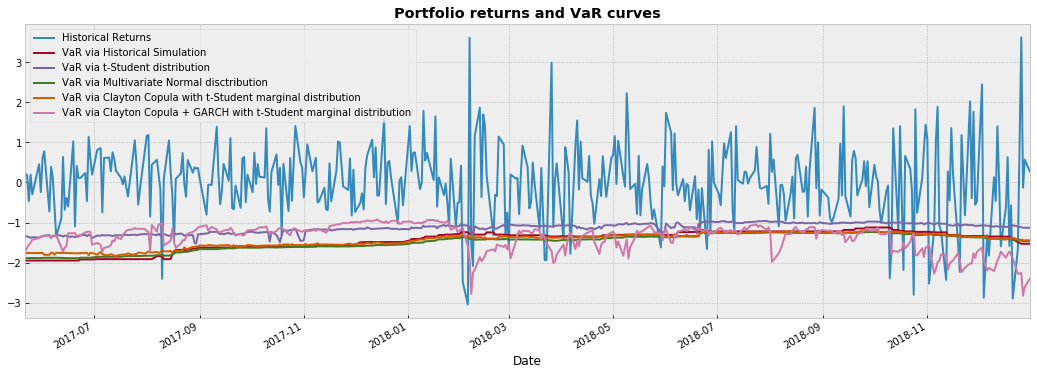

In [190]:
fig = plt.figure()
fig.set_size_inches(18,6)
portfolio.plot()
VaR_curve_HS.plot()
VaR_curve_student.plot()
VaR_curve_multivariate_normal.plot()
VaR_curve_copula_t.plot()
VaR_curve_copula_garch.plot()

plt.title("Portfolio returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via t-Student distribution',
            'VaR via Multivariate Normal disctribution',
            'VaR via Clayton Copula with t-Student marginal distribution',
           'VaR via Clayton Copula + GARCH with t-Student marginal distribution'])

###  И проведем тесты Купика

In [191]:
kupiec_test(VaR_curve_HS, portfolio)

Количество наблюдений: 406
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 7.39%

p-value теста: 0.039

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [192]:
kupiec_test(VaR_curve_student, portfolio)

Количество наблюдений: 406
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 10.34%

p-value теста: 0.000

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [193]:
kupiec_test(VaR_curve_multivariate_normal, portfolio)

Количество наблюдений: 406
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 6.16%

p-value теста: 0.301

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [194]:
kupiec_test(VaR_curve_copula_t, portfolio)

Количество наблюдений: 406
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 6.40%

p-value теста: 0.213

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [195]:
kupiec_test(VaR_curve_copula_garch, portfolio)

Количество наблюдений: 406
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 5.91%

p-value теста: 0.412

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


###  Как мы видим, самое большое p-value, а также самый близкий к нужному нам уровень пробоев оказался как раз-таки у Copula-GARCH модели -- супер!

###  А теперь перейдем к финальному этапу -- получению из всего это выгоды

###  Напишем функцию, которая подбирает веса портфеля таким образом, чтобы максимизировать различные показатели (Rerutn, -VaR и тд)

In [297]:
from scipy.optimize import minimize

# объявляем целевую функцию, которую мы будем минимизировать (поэтому в нужных местах ставим минусы)
def calculate_objective_function(weights, returns_simulation, alpha, objective_type):
    
    portfolio_simulation = np.dot(returns_simulation.values, weights)
    
    if objective_type == 'return':
        return -np.mean(portfolio_simulation)
    
    elif objective_type == 'var':
        return -np.quantile(portfolio_simulation, alpha)
    
    
def optimize(returns_simulation, alpha=0.05, objective_type='var'):
        
    init_guess = np.ones(shape=(returns.shape[1],)) / returns.shape[1]
    
    # вот тут можно поставить другие ограничения, например от -1 до 1, чтобы появилась возможность шортить -- продавать какие-то акции
    bounds = ((0.0, 1.0),) * returns.shape[1]
    
    weights = minimize(calculate_objective_function, init_guess,
                       args=(returns_simulation,alpha,objective_type), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}),
                       bounds=bounds)
    
    return weights.x

###  И используем ее, чтобы сравнить поведение разных портфелей

In [298]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 3

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_sharp = [value]
value_opt_weights_return_to_var = [value]
value_opt_weights_es_to_es = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='garch')
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_simulation, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_garch_simulation, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='sharp')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_sharp[-1]
#     value_opt_weights_sharp.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='return_to_var')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return_to_var[-1]
#     value_opt_weights_return_to_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='es_to_es')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_es_to_es[-1]
#     value_opt_weights_es_to_es.append(value_new)
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_var.pop(0)
# value_opt_weights_sharp.pop(0)
# value_opt_weights_return_to_var.pop(0)
# value_opt_weights_es_to_es.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_sharp = pd.Series(value_opt_weights_sharp, index=ret[estimation_window+T_start:].index)
# value_opt_weights_return_to_var = pd.Series(value_opt_weights_return_to_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_es_to_es = pd.Series(value_opt_weights_es_to_es, index=ret[estimation_window+T_start:].index)

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9881. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9501. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9032. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8518. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8437. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7997. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7949. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7002. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7002. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7246. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9783. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.697. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSca

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6767. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8486. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSca

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8847. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6432. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8684. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6462. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7915. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8456. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9396. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9022. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9282. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9043. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9696. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9578. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9339. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9258. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9734. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9624. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9624. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9287. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9453. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9552. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9473. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9463. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9597. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9594. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\Users\stepa\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

###  Посмотрим на график изменения стоимости нашего портфеля

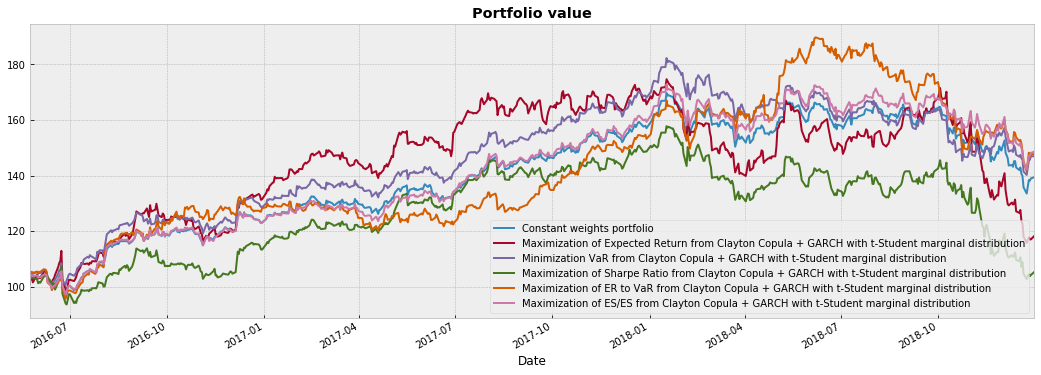

In [296]:
fig = plt.figure()
fig.set_size_inches(18,6)
value_const_weights.plot()
value_opt_weights_return.plot()
value_opt_weights_var.plot()
# value_opt_weights_sharp.plot()
# value_opt_weights_return_to_var.plot()
# value_opt_weights_es_to_es.plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Clayton Copula + GARCH with t-Student marginal distribution',
           'Minimization VaR from Clayton Copula + GARCH with t-Student marginal distribution'
#            'Maximization of Sharpe Ratio from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ER to VaR from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ES/ES from Clayton Copula + GARCH with t-Student marginal distribution'
           ])